# House prices prediction (kaggle.com)
In the Ames Housing dataset on kaggle, we would like to predict house prices with regression models. 

### Import Libraries

In [1]:
import pandas as pd
from sklearn import model_selection, linear_model, ensemble, metrics
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

## 1. Import and explore the data 

In [2]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]

In [3]:
print("The size of the training data is {}.".format(trData.shape))
print("The size of the test data is {}.".format(testData.shape))

The size of the training data is (1460, 81).
The size of the test data is (1459, 80).


The test and train data have almost the same number of samples (~1460)! 

In [4]:
trData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
trData.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


What are the missing data? 

In [6]:
trData.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
nullCounts = trData.isnull().sum()
nullCounts[nullCounts > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
nullCountsTest = testData.isnull().sum()
nullCountsTest[nullCountsTest > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [9]:
def CheckNull(df, feature):
    print(df[feature].isnull().sum())

In [10]:
testData['TotalBsmtSF'].fillna(testData['TotalBsmtSF'].mean(), inplace = True)
testData['GarageArea'].fillna(testData['GarageArea'].mean(), inplace = True)
testData['MSZoning'].fillna(testData['MSZoning'].mode()[0], inplace = True)
testData['SaleType'].fillna(testData['SaleType'].mode()[0], inplace = True)
for data in data_list:
    data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace = True)
    data['BsmtQual'].fillna(data['BsmtQual'].mode()[0], inplace = True)
    data['Functional'].fillna(data['Functional'].mode()[0], inplace = True)
    data['GarageYrBlt'].fillna(data['GarageYrBlt'].mean(), inplace = True)
    data['GarageCars'].fillna(data['GarageCars'].mode()[0], inplace = True)
    data['Electrical'].fillna(data['Electrical'].mode()[0], inplace = True)
    data['MasVnrType'].fillna(data['MasVnrType'].mode()[0], inplace = True)
    data['MasVnrArea'].fillna(data['MasVnrArea'].mean(), inplace = True)
    data['BsmtCond'].fillna(data['BsmtCond'].mode()[0], inplace = True)
    data['BsmtExposure'].fillna(data['BsmtExposure'].mode()[0], inplace = True)
    data['GarageType'].fillna(data['GarageType'].mode()[0], inplace = True)
    data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mean(), inplace = True)

In [11]:
for data in data_list:
    data['GarageTypeSmple'] = data['GarageType']
    data['GarageTypeSmple'] = data['GarageType'].replace(['Basment', 'CarPort', '2Types'], 'Rare')
    data['ExterCondSmple'] = data['ExterCond'].replace(['Fa', 'Ex', 'Po'], 'Rare')
    data['HasDeckPorch'] = ((data['WoodDeckSF'] > 0) | (data['OpenPorchSF'] > 0) | (data['EnclosedPorch']) > 0 |
                            (data['3SsnPorch'] > 0) | (data['ScreenPorch'] > 0)) * 1
    data['HasPool'] = (data['PoolArea'] > 0) * 1
    data['HalfFullBath'] = data['FullBath'] + data['HalfBath']
    data['SaleTypeSmple'] = data['SaleType'].replace(['CoD', 'ConLD', 'ConLw', 'ConLI', 'Oth', 'Con', 'CWD'], 'Rare')

Transform categorial type features to numeric:

In [12]:
combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)
Ntr = len(trData)
Ntest = len(testData)
Ntot = len(combinedData)
label = LabelEncoder()
label.fit(combinedData['Neighborhood']) 
labelZone = LabelEncoder()
labelZone.fit(combinedData['MSZoning'])
labelBldgType = LabelEncoder()
labelBldgType.fit(combinedData['BldgType'])
labelHouseStyle = LabelEncoder()
labelHouseStyle.fit(combinedData['HouseStyle'])
labelEncoderList = [LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(),
                   LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), 
                   LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(),
                   LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(),
                   LabelEncoder(), LabelEncoder()]
labelListOld = ['Neighborhood', 'MSZoning', 'BldgType', 'HouseStyle', 'Foundation', 'CentralAir', 
                'PavedDrive', 'SaleType', 'SaleCondition', 'BsmtQual', 'Heating', 'Functional', 'Street', 
               'ExterCond', 'RoofMatl', 'RoofStyle', 'LandContour', 'Condition1', 'Condition2', 'Electrical',
               'MasVnrType', 'ExterQual', 'GarageTypeSmple', 'ExterCondSmple', 'SaleTypeSmple', 'BsmtCond']
labelListNew = ['NeighborhoodCode', 'MSZoningCode', 'BldgTypeCode', 'HouseStyleCode', 'FoundationCode', 'CentralAirCode', 
                'PavedDriveCode', 'SaleTypeCode', 'SaleConditionCode', 'BsmtQualCode', 'HeatingCode', 'FunctionalCode', 
               'StreetCode', 'ExterCondCode', 'RoofMatlCode', 'RoofStyleCode', 'LandContour', 'Condition1Code', 
               'Condition2Code', 'ElectricalCode', 'MasVnrTypeCode', 'ExterQualCode', 'GarageTypeSmpleCode', 'ExterCondSmpleCode',
               'SaleTypeSmpleCode', 'BsmtCondCode']
for i in range(len(labelEncoderList)):
    labelEncoderList[i].fit(combinedData[labelListOld[i]])
for data in data_list: 
    for i in range(len(labelListOld)):
        data[labelListNew[i]] = labelEncoderList[i].transform(data[labelListOld[i]])

### Graph the price (output) and features (input) distributions:

Text(0,0.5,'Counts')

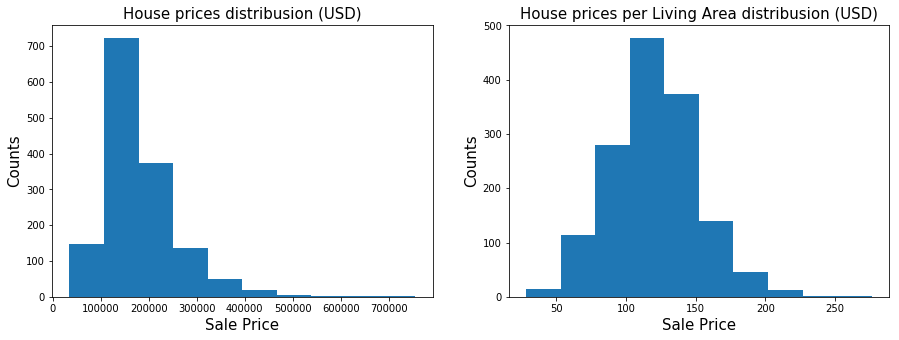

In [13]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
FZ = 15
ax[0].hist(trData['SalePrice'])
ax[0].set_title('House prices distribusion (USD)', fontsize = FZ)
ax[0].set_xlabel('Sale Price', fontsize = FZ)
ax[0].set_ylabel('Counts', fontsize = FZ)

ax[1].hist(trData['SalePrice'] / trData['GrLivArea'])
ax[1].set_title('House prices per Living Area distribusion (USD)', fontsize = FZ)
ax[1].set_xlabel('Sale Price', fontsize = FZ)
ax[1].set_ylabel('Counts', fontsize = FZ)

In [14]:
trData['PricePerArea'] = trData['SalePrice'] / trData['GrLivArea']
trData['PricePerArea'].mean()

120.57287807326857

For simplicity we will convert the price to $1000:

In [15]:
trData['SalePriceK'] = trData['SalePrice'] / 1000

The average house price per square feet of living area (GrLivArea) is around 120 USD. 

In [308]:
trData["SalePriceLog"] = np.log1p(trData["SalePrice"])

### Outliers

Text(0.5,0,'GrLivArea')

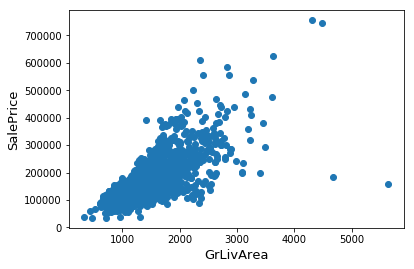

In [320]:
fig, ax = plt.subplots()
ax.scatter(x = trData['GrLivArea'], y = trData['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

In [327]:
trData = trData.drop(trData[(trData['GrLivArea']>4000) & (trData['SalePrice']<300000)].index)
combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)

## 2. Feature engineering
We investigate the correlation between the features and the sale price.

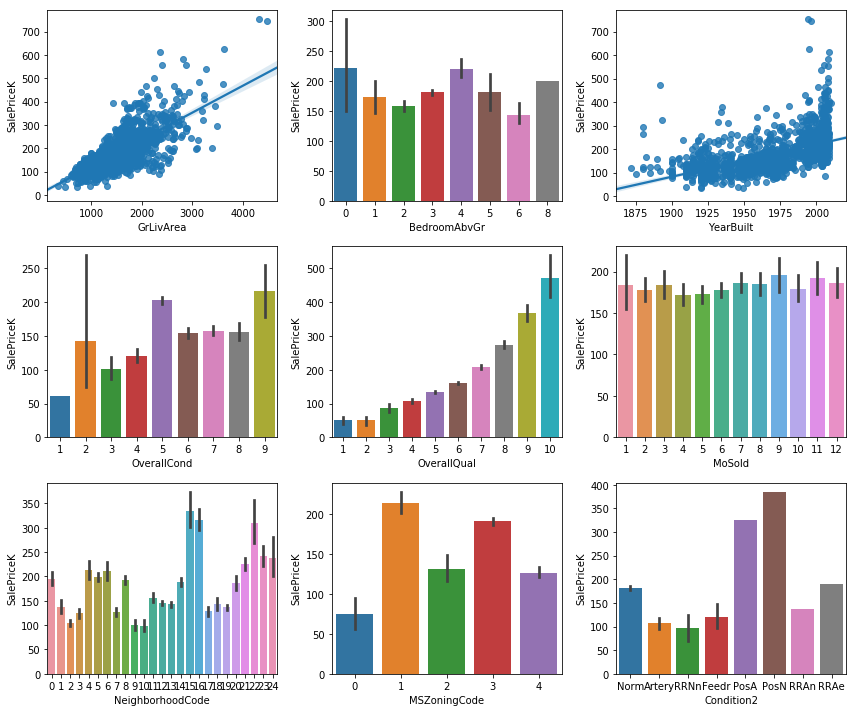

In [328]:
f, ax = plt.subplots(3, 3, figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.regplot(x = 'GrLivArea', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 2)
sns.barplot(x = 'BedroomAbvGr', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 3)
sns.regplot(x = 'YearBuilt', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 4)
sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 5)
sns.barplot(x = 'OverallQual', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 6)
sns.barplot(x = 'MoSold', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 7)
sns.barplot(x = 'NeighborhoodCode', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 8)
sns.barplot(x = 'MSZoningCode', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 9)
sns.barplot(x = 'Condition2', y = 'SalePriceK', data = trData)
plt.tight_layout() 

1Fam      1218
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64
0


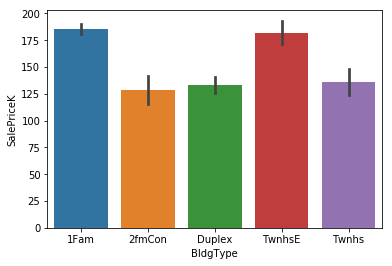

In [329]:
# tmpData = trData
# tmpData['1stFlrSF_2ndFlrSF'] = trData['1stFlrSF'] + trData['2ndFlrSF']
sns.barplot(x = 'BldgType', y = 'SalePriceK', data = trData)
print(trData['BldgType'].value_counts())
CheckNull(combinedData, 'BsmtCond')

In [330]:
CheckNull(combinedData, 'ExterQual')

0


In [331]:
for data in data_list:
    data['GarageCarsSmple'] = data['GarageCars'].replace(4, 3)

2    612
1    469
3    352
4     22
0      3
Name: HalfFullBath, dtype: int64


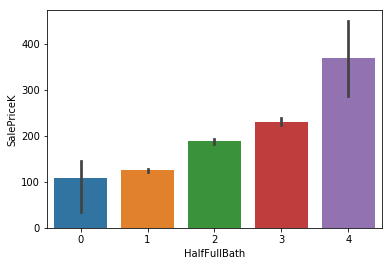

In [332]:
sns.barplot(x = 'HalfFullBath', y = 'SalePriceK', data = trData)
print(trData['HalfFullBath'].value_counts())

1    1064
0     394
Name: HasDeckPorch, dtype: int64


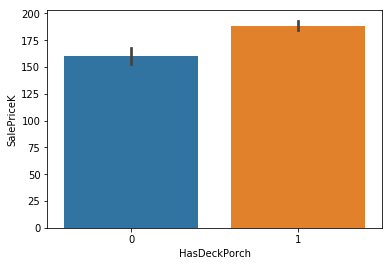

In [333]:
sns.barplot(x = 'HasDeckPorch', y = 'SalePriceK', data = trData)
print(trData['HasDeckPorch'].value_counts())

No    991
Av    221
Gd    132
Mn    114
Name: BsmtExposure, dtype: int64
0


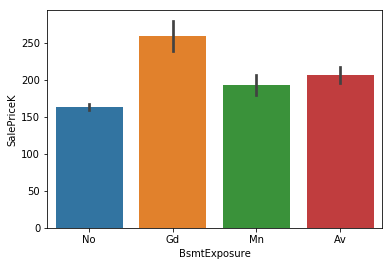

In [334]:
sns.barplot(x = 'BsmtExposure', y = 'SalePriceK', data = trData)
print(trData['BsmtExposure'].value_counts())
CheckNull(combinedData, 'BsmtExposure')

Since only 'Gd' condition has a significant different with the rest, we define a new feature: 

In [335]:
for data in data_list:
    data['BsmtExposureGd'] = (data['BsmtExposure'] == 'Gd') * 1

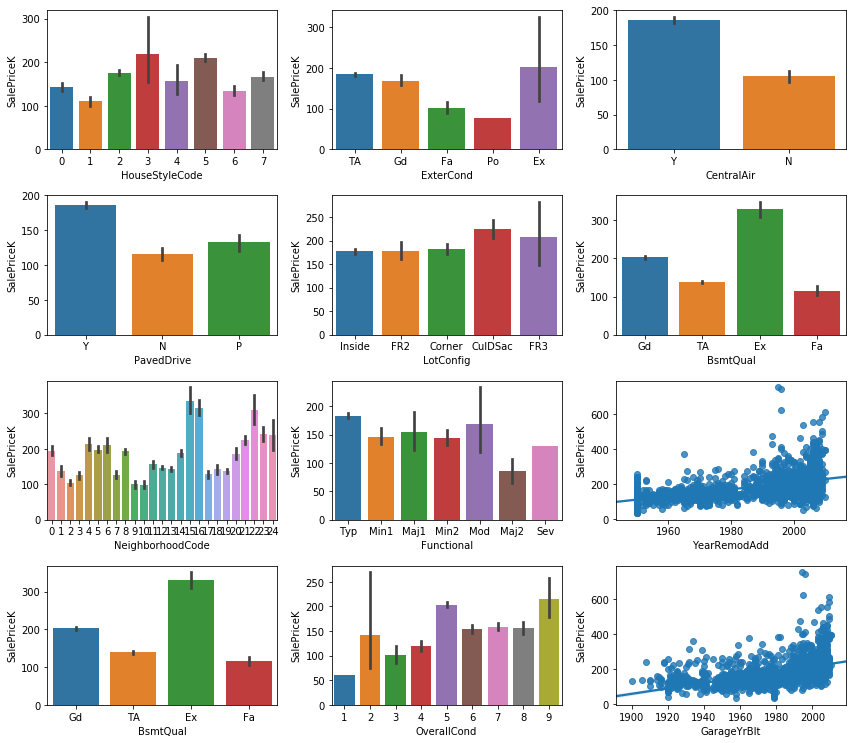

In [336]:
f, ax = plt.subplots(3, 3, figsize = (12, 10))
plt.subplot(4, 3, 1)
sns.barplot(x = 'HouseStyleCode', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 2)
sns.barplot(x = 'ExterCond', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 3)
sns.barplot(x = 'CentralAir', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 4)
sns.barplot(x = 'PavedDrive', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 5)
sns.barplot(x = 'LotConfig', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 6)
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 7)
sns.barplot(x = 'NeighborhoodCode', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 8)
sns.barplot(x = 'Functional', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 9)
sns.regplot(x = 'YearRemodAdd', y = 'SalePriceK', data = trData)
plt.tight_layout() 
plt.subplot(4, 3, 10) 
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 11) 
sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData) 
plt.subplot(4, 3, 12) 
sns.regplot(x = 'GarageYrBlt', y = 'SalePriceK', data = trData)

House age seems to be an important feature correlated with the saleprice:

In [337]:
trData['YearBuilt'].describe()

count    1458.000000
mean     1971.218107
std        30.193754
min      1872.000000
25%      1954.000000
50%      1972.500000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

In [338]:
for data in data_list:
    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['YrfromRemod'] = data['YrSold'] - data['YearRemodAdd']
    data['YrSoldFrom2006'] = data['YrSold'] - 2006
    data['YrBuiltFrom1971'] = data['YearBuilt'] - 1971

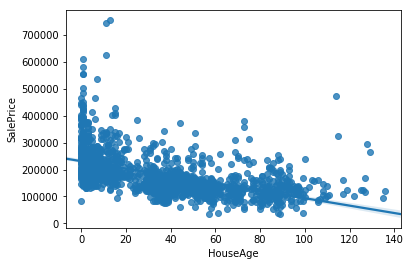

In [339]:
sns.regplot(x = 'HouseAge', y = 'SalePrice', data = trData)

In [340]:
cor_col = ['GrLivArea', 'HouseAge', 'OverallCond', 'OverallQual', 'KitchenAbvGr', 'GarageArea', 
           'Functional', 'TotalBsmtSF',  'MSSubClass', 'NeighborhoodCode', 'MSZoningCode',
           'BldgTypeCode', 'HouseStyleCode', 'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 
           'LotArea', 'RoofStyleCode', 'SalePrice']

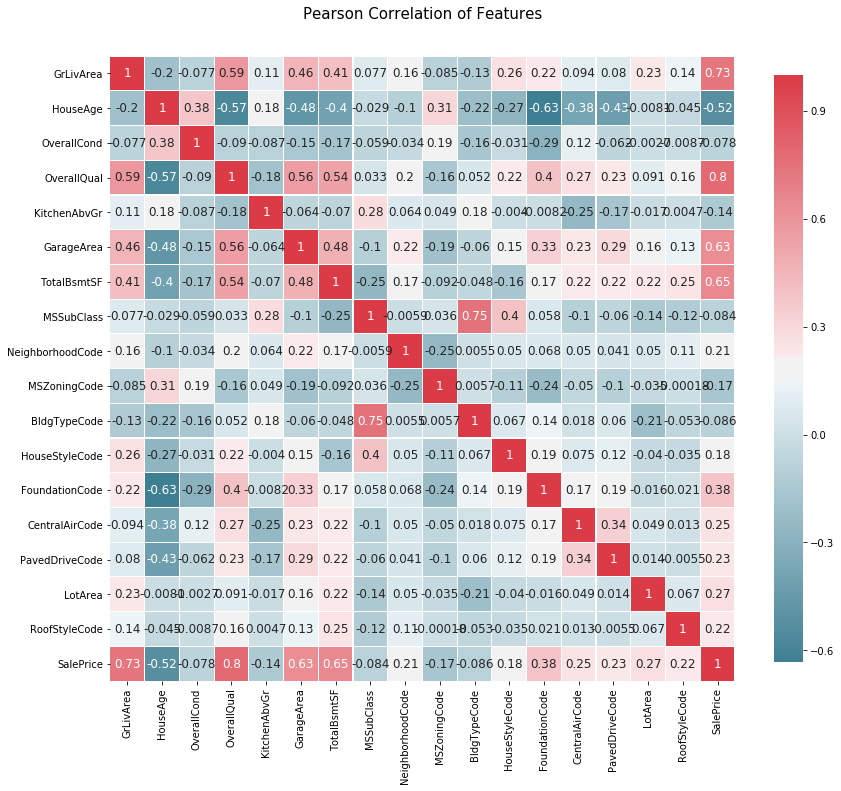

In [341]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData[cor_col])

In [342]:
combinedData['Condition2'].value_counts()

Norm      2888
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

## 3. Prediction models

In [343]:
selected_features = ['GrLivArea', 'HouseAge', 'OverallQual', 'BedroomAbvGr', 'KitchenAbvGr', 
                     'FullBath', 'GarageArea', 'Fireplaces', 'TotalBsmtSF', 'MSSubClass', 
                     'MSZoningCode', 'BldgTypeCode', 'HouseStyleCode', 
                     'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 'LotArea', 
                     'YearRemodAdd', 'BsmtQualCode', 'TotRmsAbvGrd', 'OverallCond', 'LandContour',
                     'MasVnrTypeCode', 'BsmtExposureGd', 'YearBuilt', 'GarageTypeSmpleCode', 'GarageCarsSmple',
                     'HasDeckPorch', 'BsmtFinSF1', 'NeighborhoodCode']
# good GarageCarsSmple HouseStyleCode CentralAirCode BsmtQualCode OverallCond Fireplaces TotalBsmtSF MSSubClass MSZoningCode
# bad BsmtExposureGd GarageArea FoundationCode LandContour HasDeckPorch FullBath MasVnrTypeCode BedroomAbvGr
# bad PavedDriveCode BldgTypeBsmtExposureGdCode GarageTypeSmpleCode KitchenAbvGr
selected_features = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'NeighborhoodCode', 'YearRemodAdd', 
                    'GarageCarsSmple', 'HouseStyleCode',  'TotalBsmtSF', 'LotArea', 'OverallCond', 'Fireplaces',
                    'HouseStyleCode', 'MSSubClass',  'BsmtQualCode', 'PavedDriveCode', 'MasVnrTypeCode'
                    ]

X = trData[selected_features]
y = trData['SalePrice']

In [344]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.5, train_size = 0.5, random_state=1)

Voting:

In [345]:
clfList = [linear_model.LinearRegression(), ensemble.RandomForestRegressor(), ensemble.GradientBoostingRegressor()]
cvSplit = model_selection.ShuffleSplit(n_splits = 10, train_size = 0.5, test_size = 0.5, random_state = 0)
maxDepthList = [2, 4, 6, 8, 10, None]
nEstimatorsList = [10, 50, 100, 300]
etaList = [0.1, 0.05, 0.01]
gridSeedList = [0]
gridBool = [True, False]
paramGridList = [[{'fit_intercept': gridBool}], [{'max_depth': maxDepthList, 'random_state': gridSeedList}],
                [{'max_depth': maxDepthList, 'random_state': gridSeedList}]]
bestScoreList = []
for clf, param in zip(clfList, paramGridList):
    bestSearch = model_selection.GridSearchCV(estimator = clf, param_grid = param, 
                                              cv = cvSplit, scoring = 'neg_mean_squared_error', n_jobs = 4)
    bestSearch.fit(X, y)
    bestParam = bestSearch.best_params_
    bestScore = round((-bestSearch.best_score_)**0.5, 5) / 1000
    print('The best parameter for {} is {} with a runtime of seconds with an error of {}'.format(clf.__class__.__name__, bestParam, bestScore))
    clf.set_params(**bestParam) 
    bestScoreList.append(bestScore)
print("--"*45, "\nMax cross-validation score is {}".format(round(min(bestScoreList), 5)))
print("--"*45, "\nAverage cross-validation score is {}".format(sum(sorted(bestScoreList, reverse=False)[0:3]) / 3))

The best parameter for LinearRegression is {'fit_intercept': False} with a runtime of seconds with an error of 30.009897130000002
The best parameter for RandomForestRegressor is {'max_depth': 10, 'random_state': 0} with a runtime of seconds with an error of 29.98671901
The best parameter for GradientBoostingRegressor is {'max_depth': 4, 'random_state': 0} with a runtime of seconds with an error of 26.199345649999998
------------------------------------------------------------------------------------------ 
Max cross-validation score is 26.19935
------------------------------------------------------------------------------------------ 
Average cross-validation score is 28.731987263333334


In [348]:
votingC = clfList[2]
votingC.fit(X, y) # Note we fit the Whole X, y
arpredict = votingC.predict(Xtest)
print(metrics.mean_squared_log_error(ytest, arpredict)**0.5)
predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
                         'Error': arpredict - ytest.values})

0.0898106421087


In [301]:
trsh = 100000
print(len(Xtest[abs(arpredict - ytest.values) > trsh]))
predData[abs(arpredict - ytest.values) > trsh]

0


,Error,Index,SalePrice,SalePricePredicted


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

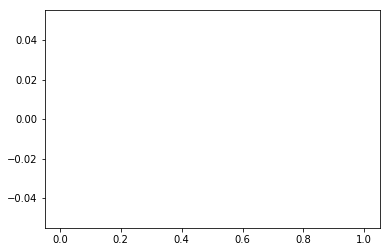

In [302]:
plt.hist(Xtest[abs(arpredict - ytest.values) > trsh]['OverallQual'])

In [36]:
ytest[abs(arpredict - ytest.values) > 100000]

798     485000
581     253293
632      82500
1324    147000
1181    392500
Name: SalePrice, dtype: int64

In [37]:
# logreg = linear_model.LinearRegression(fit_intercept=True)
# logreg.fit(Xtrain, ytrain)
# ypredict = logreg.predict(Xtest)
# # for i in range(0, len(ypredict)):
# #     if ypredict[i] < 0:
# #         ypredict[i] = 0
# print((metrics.mean_squared_log_error(ytest, ypredict))**0.5)

In [38]:
# rndForest = ensemble.RandomForestRegressor(random_state = 0)
# rndForest.fit(Xtrain, ytrain)
# ypredict = rndForest.predict(Xtest)
# for i in range(0, len(ypredict)):
#     if ypredict[i] < 0:
#         ypredict[i] = 0
# print((metrics.mean_squared_log_error(ytest, ypredict))**0.5)

In [303]:
testDataTemp = testData[selected_features]
arpredict = votingC.predict(testDataTemp)
# ypredict = pd.DataFrame({'Id': testData['Id'], 'SalePrice':arpredict}) should convert the log back!
# ypredict.to_csv('../predictions.csv', index = False)

In [40]:
ypredict.head()

,Id,SalePrice
0,1461,132246.186637
1,1462,146188.361663
2,1463,182481.552762
3,1464,184854.232918
4,1465,184707.234622
